In [1]:
import os.path
from os import path
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import ticker, cm
import numpy as np

from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel, RBF
from sklearn import gaussian_process

In [2]:
date = '10032020' # started from 03032020
vgzfile = 'klik_corona' + date + '.csv'
vgzurl = 'https://www.volksgezondheidenzorg.info/sites/default/files/map/detail_data/' + vgzfile
if not path.exists('data/' +vgzfile):
    !wget $vgzurl -P data/

In [3]:
df_NL = pd.read_csv('data/'+vgzfile,delimiter=';')

gemeenten = pd.read_csv('data/gemeenten.csv')
gemeenten = gemeenten.rename(columns={"NAAM": "Gemeente"})

df_NL['Aantal'] = df_NL['Aantal'].str.replace(",", ".").astype(float)
df_NL = df_NL.fillna(0)
print('There are {} invections in the Netherlands on {}'.format(df_NL['Aantal'].sum(),date))

dfNL = df_NL.merge(gemeenten,on='Gemeente')

There are 380.0 invections in the Netherlands on 10032020


In [4]:
BBox=np.array([3.0006408691406254,7.325906753540039,50.69414695350509,53.79928213877752])

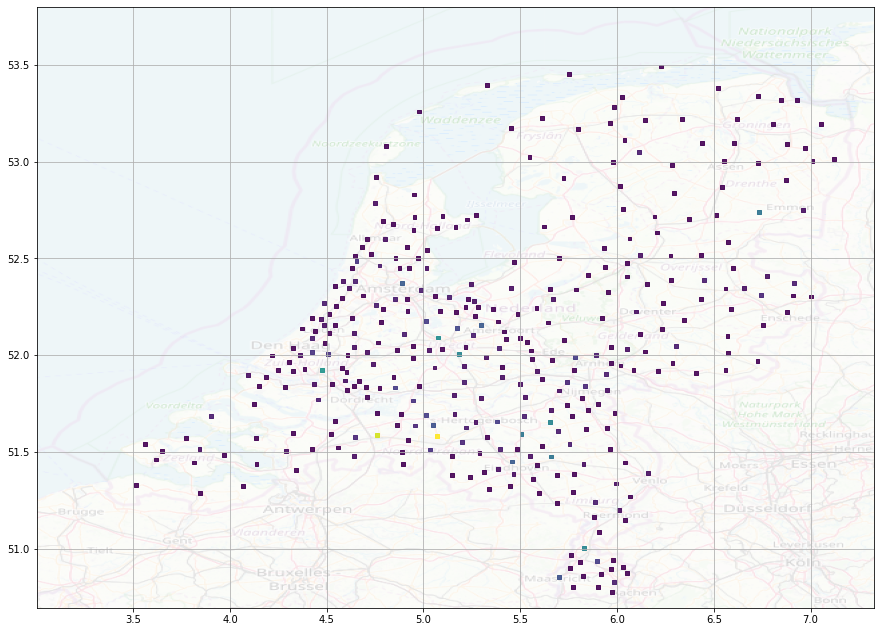

In [5]:
fig, ax = plt.subplots(figsize = (15,15))

ax.scatter(dfNL.Lon, dfNL.Lat, zorder=1, alpha= 0.9, c=dfNL.Aantal, s=15, marker='s',cmap=plt.cm.viridis)
ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])
nlMap = plt.imread('figures/mapNetherlands.png')
ax.imshow(nlMap, zorder=0, extent = BBox, aspect= 'equal',alpha=.2);
plt.grid()

In [6]:
# Keep only municipalities that have invected inhabitants
#dfNL = dfNL[dfNL['Aantal']>0]

In [7]:
# Training data
X_obs = dfNL[['Lon', 'Lat']].values
y_obs = dfNL['Aantal'].values

In [8]:
kernel = 10.0 * RBF(length_scale=.1,length_scale_bounds=(5e-2, 1e1))

gp = gaussian_process.GaussianProcessRegressor(kernel=kernel,n_restarts_optimizer=2)
gp.fit(X_obs, y_obs)

GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
                         kernel=3.16**2 * RBF(length_scale=0.1),
                         n_restarts_optimizer=2, normalize_y=False,
                         optimizer='fmin_l_bfgs_b', random_state=None)

In [9]:
nd = 200 # create grid 

z1, z2 = np.meshgrid(np.linspace(BBox[0], BBox[1], nd), np.linspace(BBox[2], BBox[3], nd))
Z = np.concatenate([z1.reshape(nd*nd, 1), z2.reshape(nd*nd, 1)], 1)

In [10]:
y_sl, std_sl = gp.predict(Z, return_std=True)
y_sl[y_sl<0] = 0 #set negative values to zero
y_sl_grid = np.reshape(y_sl,(nd,nd),'F').T
std_sl_grid = np.reshape(std_sl,(nd,nd),'F').T

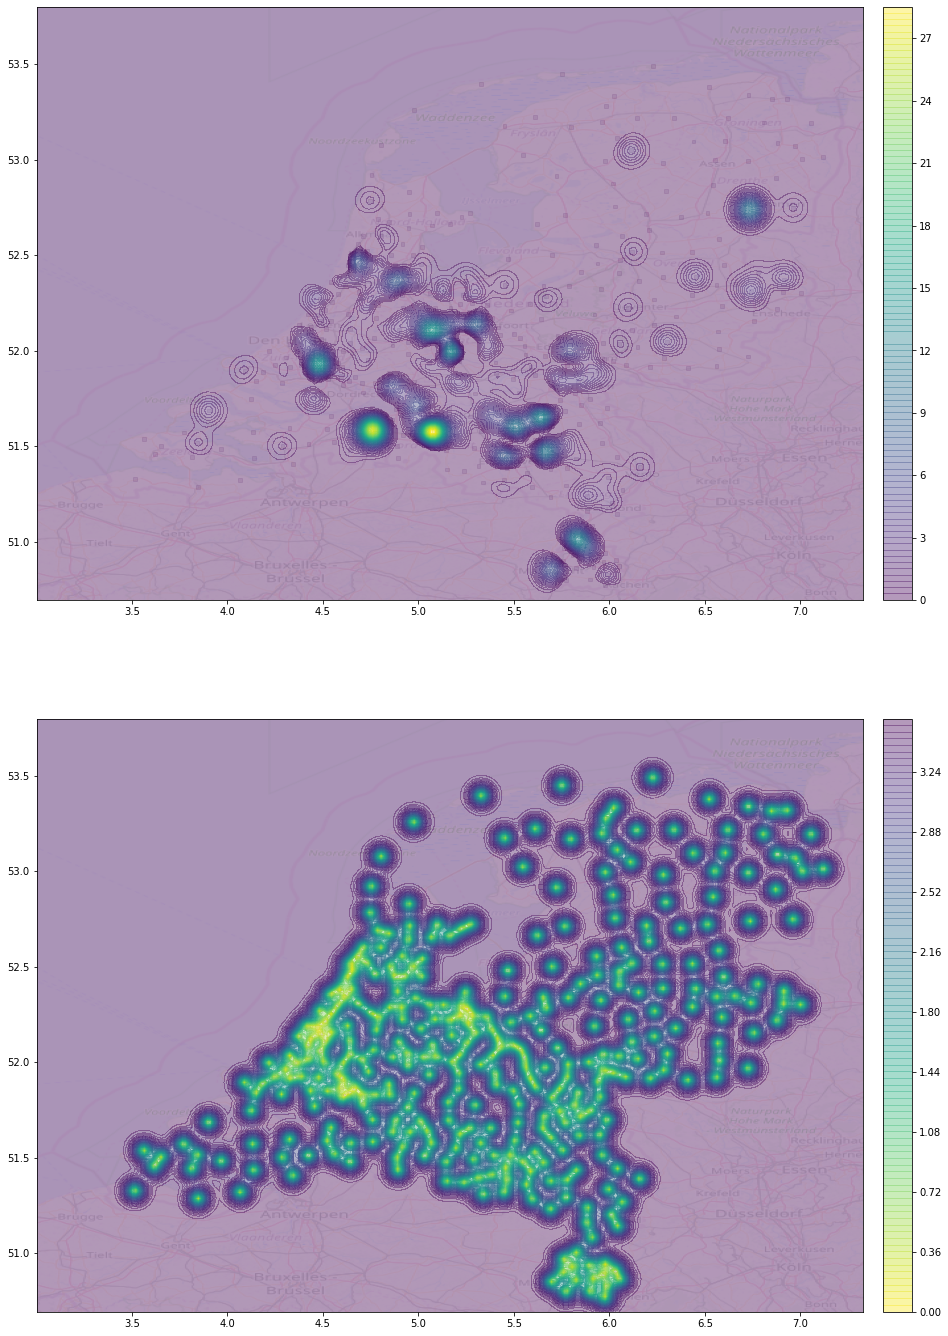

In [11]:
fig, axes = plt.subplots(nrows=2,ncols=1,figsize = (18,24))
from matplotlib.ticker import MaxNLocator

nlMap = plt.imread('figures/mapNetherlands.png')
for ax in axes:
    ax.set_xlim(BBox[0],BBox[1])
    ax.set_ylim(BBox[2],BBox[3])
    ax.imshow(nlMap, zorder=0, extent = BBox, aspect= 'equal',alpha=.2)
    ax.scatter(dfNL.Lon, dfNL.Lat, zorder=1, alpha= 0.1, c=dfNL.Aantal, s=15, marker='s',cmap=plt.cm.viridis)

cs = axes[0].contourf(z1, z2, y_sl_grid, cmap=cm.viridis, alpha=.4, levels=100)
fig.colorbar(cs,ax=axes[0],fraction=0.030, pad=0.02)

cs = axes[1].contourf(z1, z2, std_sl_grid, cmap=cm.viridis_r, alpha=.4, levels=100)
fig.colorbar(cs,ax=axes[1],fraction=0.030, pad=0.02);